In [4]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [5]:
def load_mnist(path, kind):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [6]:
import matplotlib.pyplot as plt

def graph_plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [14]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score
ami = adjusted_mutual_info_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(- w)
    acc= sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
    print('\n')
    print("Accuracy using linear assignment : ",acc)
    print('\n')
    print("Normalized Mutual Info Score : ",nmi(y_true,y_pred))
    print('\n')
    print("Adjusted Mutual Info Score : ",ami(y_true,y_pred))
    


In [9]:
#Load the data

X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [10]:
#Kmeans without Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train)

predicted_labels=model.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix

print ('Results of Kmeans without Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

acc(y_test,predicted_labels)

Results of Kmeans without Autoencoder


Confusion Matrix: 

[[ 29   6 587   0  93   1  34 245   5   0]
 [890   0  50   0  22   0   9  29   0   0]
 [  4   4  19   0  61   0 566 342   4   0]
 [503   2 277   0  92   0  10 113   3   0]
 [ 27   4 136   0  42   0 627 159   5   0]
 [  0   0   0  72 650 227   0   6   0  45]
 [ 12  15 189   0 115   0 311 358   0   0]
 [  0   0   0 151  62 785   0   0   0   2]
 [  6 351   3   9  84  40  62  36 408   1]
 [  0   0   0 519  29  23   0   4   2 423]]


Accuracy using linear assignment :  0.4828


Normalized Mutual Info Score :  0.5127573568302513


Adjusted Mutual Info Score :  0.500295735526428


In [48]:
#Load and preprocess the data

X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')

max_value = float(X_train.max())
X_train = X_train.astype('float32') / max_value
X_test = X_test.astype('float32') / max_value

In [49]:
#Autoencoder Simple version

# input dimension = 784
input_dim = X_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()



Compression factor: 24.5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [50]:
#create an encoder model to implement dimension reduction
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Train the autoencoder model

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
aehistory=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.4140 - val_loss: 0.3427
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3279 - val_loss: 0.3202
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3120 - val_loss: 0.3087
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3023 - val_loss: 0.3007
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.2957 - val_loss: 0.2954
Epoch 6/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.2916 - val_loss: 0.2924
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2892 - val_loss: 0.2905
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2876 - val_loss: 0.2892
Epoch 9/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2865 - val_loss: 0.2882
Epoch

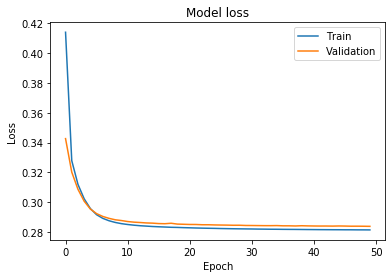

In [52]:
#Plot Training vs Validation Loss for the above

graph_plot_loss(aehistory)

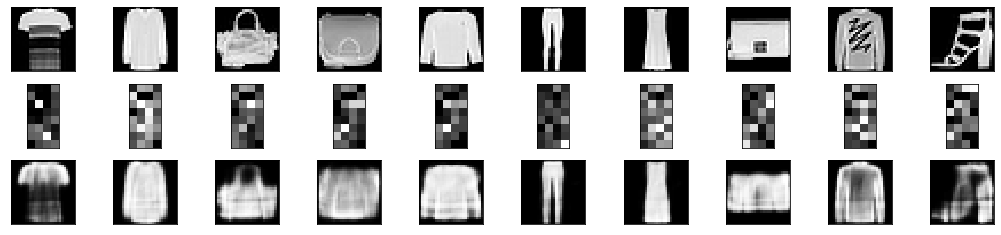

In [53]:
#viewing my autoencoder

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [54]:
#Now perform dimension reduction

X_train_dr=encoder.predict(X_train)
X_test_dr=encoder.predict(X_test)

X_train_dr.shape,X_test_dr.shape

((60000, 32), (10000, 32))

In [55]:
#Kmeans using simple autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)

In [56]:

from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Simple Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

acc(y_test,predicted_labels)

Results of Kmeans with Simple Autoencoder


Confusion Matrix: 

[[  0 537 299  11   2   0   1  26  73  51]
 [800   6  65   0   0   0   0  14  98  17]
 [  0  12 232 392   1   0   0 317   3  43]
 [  0  21 181   7   0   0   0  40 539 212]
 [  0   2  83 495   2   0   0 173  19 226]
 [  0   0 458   0  87  46 381  28   0   0]
 [  0 127 284 232   4   0   0 235  37  81]
 [  0   0  34   0 243   6 717   0   0   0]
 [  0   1 199  23 257   0  38 469   9   4]
 [  0   1  46   0 343 586  17   6   1   0]]


Accuracy using linear assignment :  0.4787


Normalized Mutual Info Score :  0.47842061910866224


Adjusted Mutual Info Score :  0.47095945449963783


In [57]:
#Gaussian Mixture Model with Simple Autoencoder

from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


from sklearn.metrics import confusion_matrix

print ('Results of Gaussian Mixture Model with Simple Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

acc(y_test,plabels)

Results of Gaussian Mixture Model with Simple Autoencoder


Confusion Matrix: 

[[  4  31  76  25  62   0  51   0 751   0]
 [  0 153   6  45  18   0   3   0   4 771]
 [  1   2  16   7  80   0 872   0  22   0]
 [  0 459 355  37  31   0  51   0  67   0]
 [  1   3 127   7  64   0 793   0   5   0]
 [152   0   0   2   1 410   0 435   0   0]
 [  3  10  88  20  90   0 574   0 215   0]
 [227   0   0   0   0 727   0  46   0   0]
 [285   3   2  60 636   0   8   3   3   0]
 [127   0   0   4   1   7   0 861   0   0]]


Accuracy using linear assignment :  0.5376


Normalized Mutual Info Score :  0.5853640533698512


Adjusted Mutual Info Score :  0.5669261845589347


In [25]:
#Deep autoencoder model

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
________________________________________________

In [26]:
#encoder model for dimension reduction

input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Training the model

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
aehistory= autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                validation_data=(X_test, X_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.3801 - val_loss: 0.3186
Epoch 2/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.3100 - val_loss: 0.3071
Epoch 3/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.3013 - val_loss: 0.3004
Epoch 4/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2966 - val_loss: 0.2969
Epoch 5/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.2936 - val_loss: 0.2944
Epoch 6/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.2916 - val_loss: 0.2928
Epoch 7/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.2900 - val_loss: 0.2912
Epoch 8/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.2885 - val_loss: 0.2900
Epoch 9/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2871 - val_loss: 0.2890
Epoch

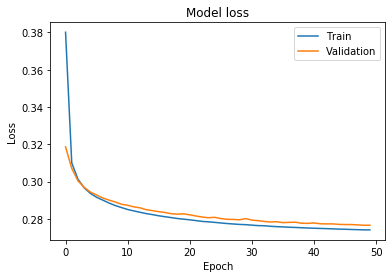

In [28]:
#Plot Training vs Validation Loss for the above

graph_plot_loss(aehistory)

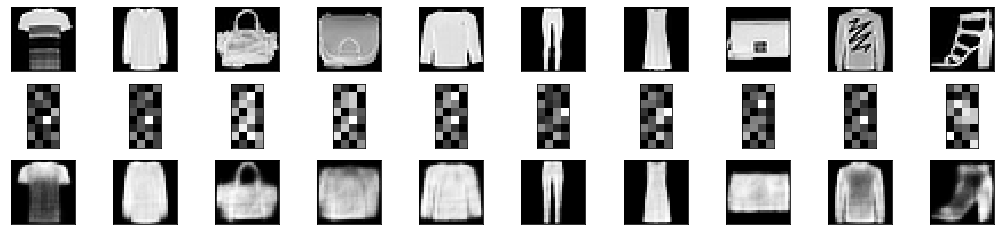

In [29]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
#Now perform dimension reduction

X_train_dr=encoder.predict(X_train)
X_test_dr=encoder.predict(X_test)

X_train_dr.shape,X_test_dr.shape

((60000, 32), (10000, 32))

In [31]:
# Kmeans with Deep Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)

from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Deep Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

acc(y_test,predicted_labels)

Results of Kmeans with Deep Autoencoder


Confusion Matrix: 

[[  1  85   0   2 568   1   1  25   0 317]
 [  0 330   0   0   8   0 580   9   0  73]
 [  3   6   0   6  15   0   0 606   0 364]
 [  1 585   0   7  45   0 163  25   0 174]
 [  2 112   0  12   4   0   0 695   0 175]
 [263   0 235   0   0 279   0   0 138  85]
 [  5  56   0  16 157   0   2 316   0 448]
 [112   0 345   0   0 480   0   0  62   1]
 [280  25   3 433   2  66   0  23   0 168]
 [160   2   4   8   0 142   0   0 653  31]]


Accuracy using linear assignment :  0.4705


Normalized Mutual Info Score :  0.4832050389619245


Adjusted Mutual Info Score :  0.4732735518933073


In [39]:
#Gaussian Mixture Model with Deep Autoencoder

from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


from sklearn.metrics import confusion_matrix

print ('Results of Gaussian Mixture Model with Deep Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

acc(y_test,plabels)

Results of Gaussian Mixture Model with Deep Autoencoder


Confusion Matrix: 

[[  0  21  49  94   0   0   6 126   2 702]
 [  0   2  60  16   0 807   4 111   0   0]
 [  1   4  51 730   0   0 192  11   3   8]
 [  0   4  38 109   0   0   0 828   0  21]
 [  0   3  31 761   0   0 126  76   2   1]
 [ 99   3  22   1 438   0   0   0 437   0]
 [  0  26  27 592   0   0  73  92   3 187]
 [206   0   0   0 768   0   0   0  26   0]
 [  8 744  81  49   2   0   2  10 104   0]
 [875   1  48   0  19   0   0   0  57   0]]


Accuracy using linear assignment :  0.6141


Normalized Mutual Info Score :  0.599561345684532


Adjusted Mutual Info Score :  0.581541389314918


In [33]:
#Preprocessing for convolution autoencoder

x_train = X_train.reshape((len(X_train), 28, 28, 1))
x_test = X_test.reshape((len(X_test), 28, 28, 1))


x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [34]:

#Convolution Autoencoder

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

In [35]:
#The encoder model based on convolution autoencoder

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0   

In [36]:
#Train the convolution autoencoder

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
aehistory=autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 68s 1ms/step - loss: 0.3502 - val_loss: 0.3017
Epoch 2/100
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2956 - val_loss: 0.2946
Epoch 3/100
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2907 - val_loss: 0.2915
Epoch 4/100
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2882 - val_loss: 0.2892
Epoch 5/100
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2865 - val_loss: 0.2877
Epoch 6/100
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2852 - val_loss: 0.2866
Epoch 7/100
60000/60000 [==============================] - 71s 1ms/step - loss: 0.2841 - val_loss: 0.2859
Epoch 8/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2832 - val_loss: 0.2848
Epoch 9/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.2825 - val_loss: 0.2

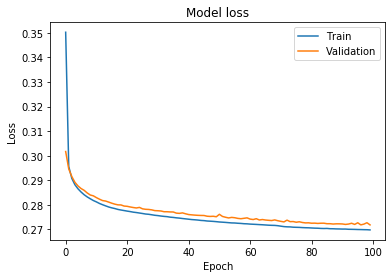

In [37]:
#Plot Training vs Validation Loss for the above

graph_plot_loss(aehistory)

autoencoder.save_weights('autoencoder_cnn.h5')

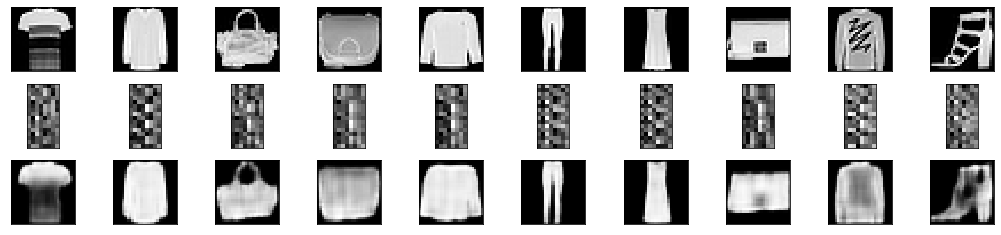

In [38]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [41]:
#Now perform dimension reduction

X_train_dr=encoder.predict(x_train)
X_test_dr=encoder.predict(x_test)

print(X_train_dr.shape,X_test_dr.shape)



(60000, 128) (10000, 128)


In [42]:
#Kmeans with Convolution Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)


from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

acc(y_test,predicted_labels)

Results of Kmeans with Convolution Autoencoder


Confusion Matrix: 

[[ 32   2 227   0  21   6   5 112   0 595]
 [ 11   0  17   0 854   1   0 116   0   1]
 [612   0 347   0   1   5   0  27   0   8]
 [ 14   0  76   0 478   1   0 420   0  11]
 [644   0 151   0  14   4   2 185   0   0]
 [  0 509  14 217   0   0   0   0 260   0]
 [349   2 366   0   7  20   0 126   0 130]
 [  0 774   0 222   0   0   0   0   4   0]
 [ 49  43  49   3  16 405 403  31   0   1]
 [  1  31   1 490   0   1   0   2 474   0]]


Accuracy using linear assignment :  0.4811


Normalized Mutual Info Score :  0.5498753923977981


Adjusted Mutual Info Score :  0.538695454886799


In [44]:
#Gaussian Mixture Model for Convolution Autoencoder

from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


from sklearn.metrics import confusion_matrix

print ('Results of Gaussian Mixture Model with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

acc(y_test,plabels)

Results of Gaussian Mixture Model with Convolution Autoencoder


Confusion Matrix: 

[[  0 107   3 172   0  10  37   0 671   0]
 [  0  83   0  36   0 880   1   0   0   0]
 [  0  21 709 260   0   0   5   0   5   0]
 [  0 611   5 104   0 259   4   0  17   0]
 [  0 165 658 176   0   0   1   0   0   0]
 [421   0   0   1   1   0   9 365   0 203]
 [  0  93 434 262   0   2  31   0 178   0]
 [697   0   0   0   5   0   1   5   0 292]
 [  3   2   0 134   0   0 859   1   0   1]
 [  5   0   0   1 555   0   2  44   0 393]]


Accuracy using linear assignment :  0.5609


Normalized Mutual Info Score :  0.6103893561517201


Adjusted Mutual Info Score :  0.6010575572381676
